In [30]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.util import ngrams
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [31]:
df = pd.read_csv('data/opinionesGuggenheim.csv')

In [32]:
df.head(5)

,Unnamed: 0,fechasComentarios,comentarios,review_date
0,1,13 octubre 2018,Lugar recomendado para empaparse de arte y pas...,2018-10-13
1,2,13 octubre 2018,"Toda la zona exterior es increíble, tiene un t...",2018-10-13
2,3,11 octubre 2018,"Es un museo curioso por fuera, pero vergonzoso...",2018-10-11
3,4,11 octubre 2018,Fui a esta bella ciudad solamente con la final...,2018-10-11
4,5,10 octubre 2018,Increible ver su construccion y recibir inform...,2018-10-10


In [33]:
df.shape

(8617, 4)

In [34]:
df.dtypes

Unnamed: 0            int64
fechasComentarios    object
comentarios          object
review_date          object
dtype: object

In [35]:
#Parseando Tipos
df['review_date'] = pd.to_datetime(df.review_date)
df['comentarios'] = df['comentarios'].astype('str') 
#df = df.sort_values('review_date', ascending=True)

In [36]:
df.dtypes

Unnamed: 0                    int64
fechasComentarios            object
comentarios                  object
review_date          datetime64[ns]
dtype: object

(array([731581., 732312., 733042., 733773., 734503., 735234., 735964.,
        736695., 737425.]),
 <a list of 9 Text xticklabel objects>)

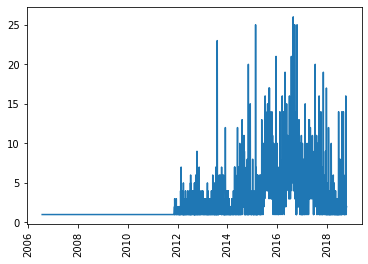

In [37]:
#Evolutivo por tiempo
graph = df.groupby('review_date').agg('count').sort_values('review_date').reset_index()
plt.plot(graph['review_date'], graph['comentarios'])
plt.xticks(rotation='vertical')

In [38]:
#Tokenizando
df['tokens'] = df.apply(lambda row: nltk.word_tokenize(re.sub('\.|,',' ',str(row['comentarios']))), axis=1)
df_tokens = df.explode('tokens')

In [39]:
graph = df_tokens.value_counts('tokens')
graph

tokens
de             8052
la             6017
y              5258
que            5189
el             4667
               ... 
fantàstica        1
fantàstico        1
turisitica        1
fanática          1
emocionante       1
Length: 11459, dtype: int64

In [40]:
#Filtro palabras de un caracter, stopwords y palabras con muchos puntos seguidos
nltk_words = list(stopwords.words('spanish'))
def filtrar(x):
    if x is None:
        return False
    if re.match('^[a-zA-ZáéíóúÁÉÍÓÚñÑ]{2,}',x) is None or x in nltk_words:
        return False
    else: 
        return True
#df_filter1 = df_tokens[(df_tokens['tokens'].str.match('^.{1}$') == False) & (df_tokens['tokens'].isin(nltk_words) == False) & (df_tokens['tokens'].str.match('^\.+') == False)]

In [41]:
df_filter1 = df_tokens[df_tokens['tokens'].apply(filtrar)]

In [42]:
df_filter1.value_counts('tokens')

tokens
Más              3910
museo            2131
edificio         1612
nan              1512
Bilbao           1405
                 ... 
haberme             1
habias              1
habilitado          1
habitacion          1
ABSOLUTAMENTE       1
Length: 10943, dtype: int64

In [43]:
#Stemming
stemmer = SnowballStemmer('spanish')
df_filter1['tokens_stem'] = df_filter1.tokens.apply(lambda i: stemmer.stem(i))

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
df_filter1.value_counts('tokens_stem')

tokens_stem
mas           4240
muse          2669
visit         2141
exposicion    1789
edifici       1742
              ... 
irrebat          1
irreal           1
irradi           1
iros             1
imbecil          1
Length: 5213, dtype: int64

In [45]:
#bigrama
df['bigram'] = df.tokens.apply(lambda i: np.asarray(list(ngrams(i,2))))
df_bigram = df.explode('bigram')
df_bigram['bigram1'] = df_bigram.bigram.apply(lambda i: str(i[0]) if isinstance(i,(list,np.ndarray)) else None)
df_bigram['bigram2'] = df_bigram.bigram.apply(lambda i: str(i[1]) if isinstance(i,(list,np.ndarray)) else None)

In [46]:
df_bigram

,Unnamed: 0,fechasComentarios,comentarios,review_date,tokens,bigram,bigram1,bigram2
0,1,13 octubre 2018,Lugar recomendado para empaparse de arte y pas...,2018-10-13,"[Lugar, recomendado, para, empaparse, de, arte...","[Lugar, recomendado]",Lugar,recomendado
0,1,13 octubre 2018,Lugar recomendado para empaparse de arte y pas...,2018-10-13,"[Lugar, recomendado, para, empaparse, de, arte...","[recomendado, para]",recomendado,para
0,1,13 octubre 2018,Lugar recomendado para empaparse de arte y pas...,2018-10-13,"[Lugar, recomendado, para, empaparse, de, arte...","[para, empaparse]",para,empaparse
0,1,13 octubre 2018,Lugar recomendado para empaparse de arte y pas...,2018-10-13,"[Lugar, recomendado, para, empaparse, de, arte...","[empaparse, de]",empaparse,de
0,1,13 octubre 2018,Lugar recomendado para empaparse de arte y pas...,2018-10-13,"[Lugar, recomendado, para, empaparse, de, arte...","[de, arte]",de,arte
...,...,...,...,...,...,...,...,...
8612,8613,19 septiembre 2007,Más,2007-09-19,[Más],NaN,None,None
8613,8614,17 junio 2007,Más,2007-06-17,[Más],NaN,None,None
8614,8615,14 octubre 2006,Más,2006-10-14,[Más],NaN,None,None
8615,8616,2 octubre 2006,Más,2006-10-02,[Más],NaN,None,None


In [47]:
#filtramos para que quede limpio el bigrama
df_bigram_filtered = df_bigram[(df_bigram['bigram1'].apply(filtrar)) & (df_bigram['bigram2'].apply(filtrar))]
df_bigram_filtered_res = df_bigram_filtered.groupby(['bigram1','bigram2']).size().sort_values(ascending=False)
df_bigram_filtered_res

bigram1        bigram2       
El             edificio          353
arte           moderno           283
El             museo             230
Las            exposiciones      161
visita         obligada          145
                                ... 
maravilla      visita              1
maravillado    admira              1
maravillados   después             1
maravillarme   cada                1
ABSOLUTAMENTE  imprescindible      1
Length: 24080, dtype: int64

In [48]:
df_bigram_filtered_res = df_bigram_filtered.groupby(['bigram1','bigram2']).size().sort_values(ascending=False)
df_bigram_filtered_res

bigram1        bigram2       
El             edificio          353
arte           moderno           283
El             museo             230
Las            exposiciones      161
visita         obligada          145
                                ... 
maravilla      visita              1
maravillado    admira              1
maravillados   después             1
maravillarme   cada                1
ABSOLUTAMENTE  imprescindible      1
Length: 24080, dtype: int64

In [49]:
# Grafico de red de palabras 
G = nx.Graph()

for k, v in df_bigram_filtered_res.items():
    if (v > 20):
        G.add_edge(k[0], k[1], weight=(v * 20))



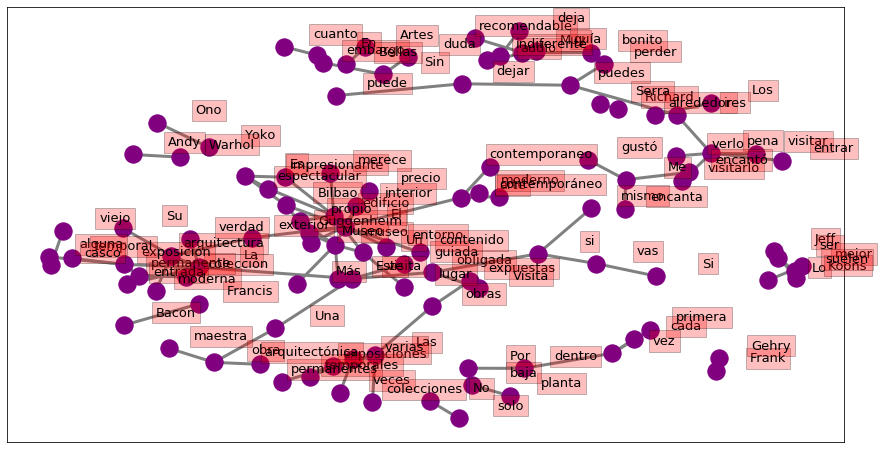

In [50]:
fig, ax = plt.subplots(figsize=(15, 8))

pos = nx.spring_layout(G, k=2)

nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

In [71]:
df_x = df_filter1.groupby(['Unnamed: 0'])['tokens'].transform(lambda x : ' '.join(x))
df['comentario_clean'] = df_x.drop_duplicates()
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform((df[df.comentario_clean.notnull()])['comentario_clean'])

In [77]:
# imprimir topicos
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nCluster #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        

number_topics = 4
number_words = 7

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
print("Clusters LDA:")
print_topics(lda, count_vectorizer, number_words)

Clusters LDA:

Cluster #0:
visita bilbao si más museo edificio pena

Cluster #1:
museo arte edificio más exposiciones el pena

Cluster #2:
museo más exposiciones el edificio bilbao arquitectura

Cluster #3:
bilbao museo ciudad paseo más edificio ría
